# Currents in the Haldane model

In [52]:
import numpy as np
from scipy.linalg import eigh
from scipy.optimize import root
import matplotlib.pyplot as plt
# For Voronoi plots
from scipy.spatial import Voronoi
import matplotlib as mpl
import matplotlib.cm as cm

from lattice import OpenLattice
from hamiltonian import OpenHamiltonian
from plot_lattice import plot_voronoi

## Hamiltonian parameters

Hamiltonian:

$$ H = \sum_{ij} A_{ij}\ c^\dagger_i c_j = t_1 \sum_{\langle ij\rangle} c^\dagger_i c_j + t_2 \sum_{\langle\langle ij\rangle\rangle} e^{i\phi_{ij}} c^\dagger_i c_j $$

In [53]:
# Lattice sizes
Nx = Ny = 25
N = 300

# Haldane Hamiltonian's parameters
t1 = 1
t2 = 1
dphi = 0.5
lattice_imbalance = 0

# Harmonica trap strength
trap_potential = 1/20

lattice = OpenLattice(Nx, Ny)
hopping_params = (t1, t2, dphi)
hoppings_type = 'haldane'
ham = OpenHamiltonian(lattice, hopping_params, hoppings_type,
                      trap_potential, lattice_imbalance)

print(f'Number of sites = {lattice.L}')
print(f'Number of particles = {N}')

Number of sites = 1250
Number of particles = 300


## Hamiltonian diagonalization

$$ H = \sum_{ij} c^\dagger_i A_{ij} c_j = \sum_{ij} c^\dagger_i V_{im} D_m V^*_{jm} c_j = \sum_m f^\dagger_m D_m f_m $$

Therefore the new basis is

$$f^\dagger_m = \sum_i V_{im} c^\dagger_i,\quad f_m = \sum_i V^*_{im} c_i $$

The occupation numbers of these new basis at a finite temperature $\beta$ are given by the Fermi-Dirac distribution

$$ \langle f^\dagger_m f_n \rangle = \delta_{mn}\frac{1}{1+e^{\beta(E_m - \mu)}}$$

with $E_m$ the eigenenergy of $f^\dagger_m$ and $\mu$ the chemical potential, which we must adjust so that the number of particles equals a chose one

$$ \langle N(\mu)\rangle = \sum_m \langle f^\dagger_m f_m \rangle = \sum_m \frac{1}{1+e^{\beta(E_m - \mu)}}$$

The expected values of the two-body operators at finite temperature are

$$ \Gamma_{ij} = \langle c^\dagger_i c_j\rangle = \sum_{mn} V^*_{im} V_{jn} \langle f^\dagger_m f_n\rangle = \sum_m V^*_{im} V_{jm} \frac{1}{1+e^{\beta (E_m - \mu)}}$$

In [54]:
w_eig, v_eig = eigh(ham.A)

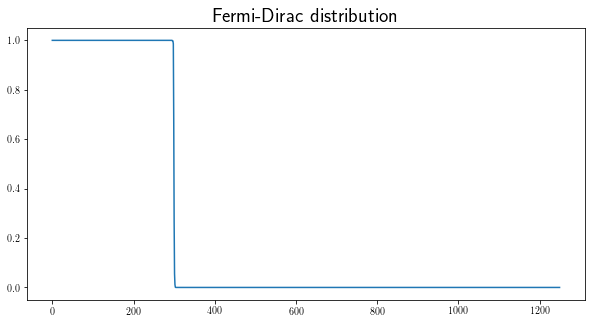

In [55]:
# Temperature
β = 100

# Computation of the chemical potential
def particle_number_with_mu(μ, w, β, N):
    """Particle number with a given chemical potential.
    
    Args:
        μ (float): chemical potential.
        w (1darray of floats): single-particle Hamiltonian spectrum.
        β (float): inverse temperature.
        N (int or float): expected number of particles.
        
    Returns:
        (float): deviation of the particle number with μ with respect
            to N.
            
    """
    return np.sum(1/(1+np.exp(β*(w-μ)))) - N

μ_0 = (w_eig[N-1] + w_eig[N])/2
sol = root(particle_number_with_mu, μ_0, args=(w_eig, β, N))
μ = sol.x

# Fermi-Dirac distribution
fd_dist = 1/(1 + np.exp(β*(w_eig-μ)))

# Plot the Fermi-Dirac distribution
plt.figure(figsize=(10, 5))
plt.plot(fd_dist)
plt.title('Fermi-Dirac distribution', fontsize=20)
plt.show()

# Expected values
Γ = np.einsum('im,jm,m->ij', np.conj(v_eig), v_eig, fd_dist, optimize=True)

## Occupation numbers


Maximum occupation: 0.9996627320101023


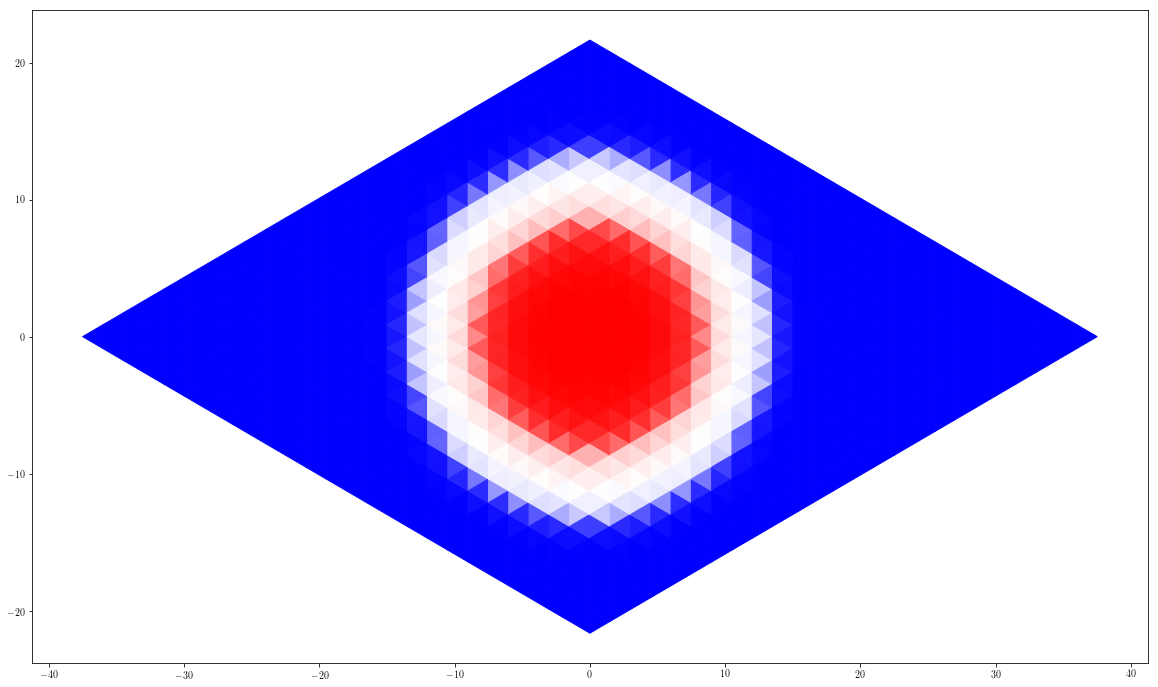

In [56]:
occupations = np.real(np.diag(Γ))
plot_voronoi(lattice, occupations, colormap='bwr')

print('Maximum occupation: {}'.format(np.max(occupations)))

## Currents

The time variation of the occupation number is
$$ \langle\frac{d}{dt}n_i\rangle = -i\langle\left[n_i,\ H\right]\rangle = -i\left(\sum_j A_{ij}\ \langle c^\dagger_i c_j\rangle - A_{ji}\ \langle c^\dagger_j c_i\rangle\right) = 2\sum_j \textit{Im} \left[A_{ij}\ \langle c^\dagger_i c_j\rangle\right]= 2\sum_j \textit{Im} \left[A_{ij}\ \Gamma_{ij}\right]$$

The current flowing from site $i$ to site $j$ can be defined as

$$ J_{ij} = 2\ \textit{Im}\left[ A_{ij}\ \langle c^\dagger_i c_j\rangle\right] = 2\ \textit{Im}\left[ A_{ij}\ \Gamma_{ij}\right] $$

The current conservation law is thus conserved as

$$ \langle\frac{d}{dt}n_i\rangle = \sum_j J_{ij} $$

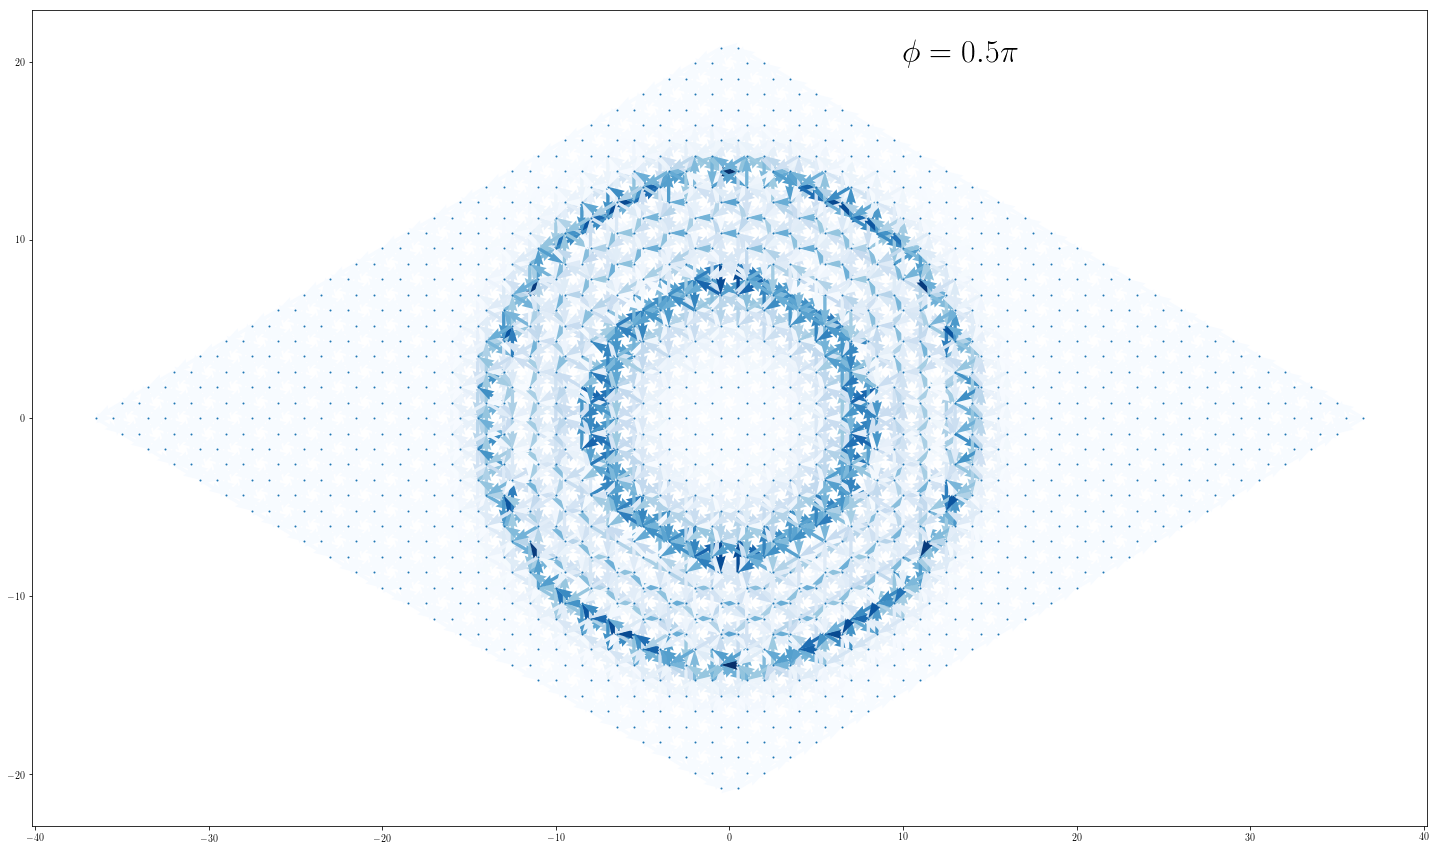

In [57]:
currents = 2*np.imag(ham.A*Γ)

ij = np.nonzero(currents > 0)

x = lattice.xy_coords[ij[0], 0]
y = lattice.xy_coords[ij[0], 1]
u = lattice.xy_coords[ij[1], 0] - x
v = lattice.xy_coords[ij[1], 1] - y
c = currents[ij]

fig = plt.figure(figsize=(25, 15))
plt.quiver(x, y, u, v, c, cmap='Blues', scale=1, units='xy', angles='xy', scale_units='xy')
plt.scatter(lattice.xy_coords[:, 0], lattice.xy_coords[:, 1], s=1)
plt.text(10, 20, r'$\phi = {}\pi$'.format(dphi), fontsize=32)
# plt.savefig('./images/two_point_currents_phi_0.pdf')
plt.show()

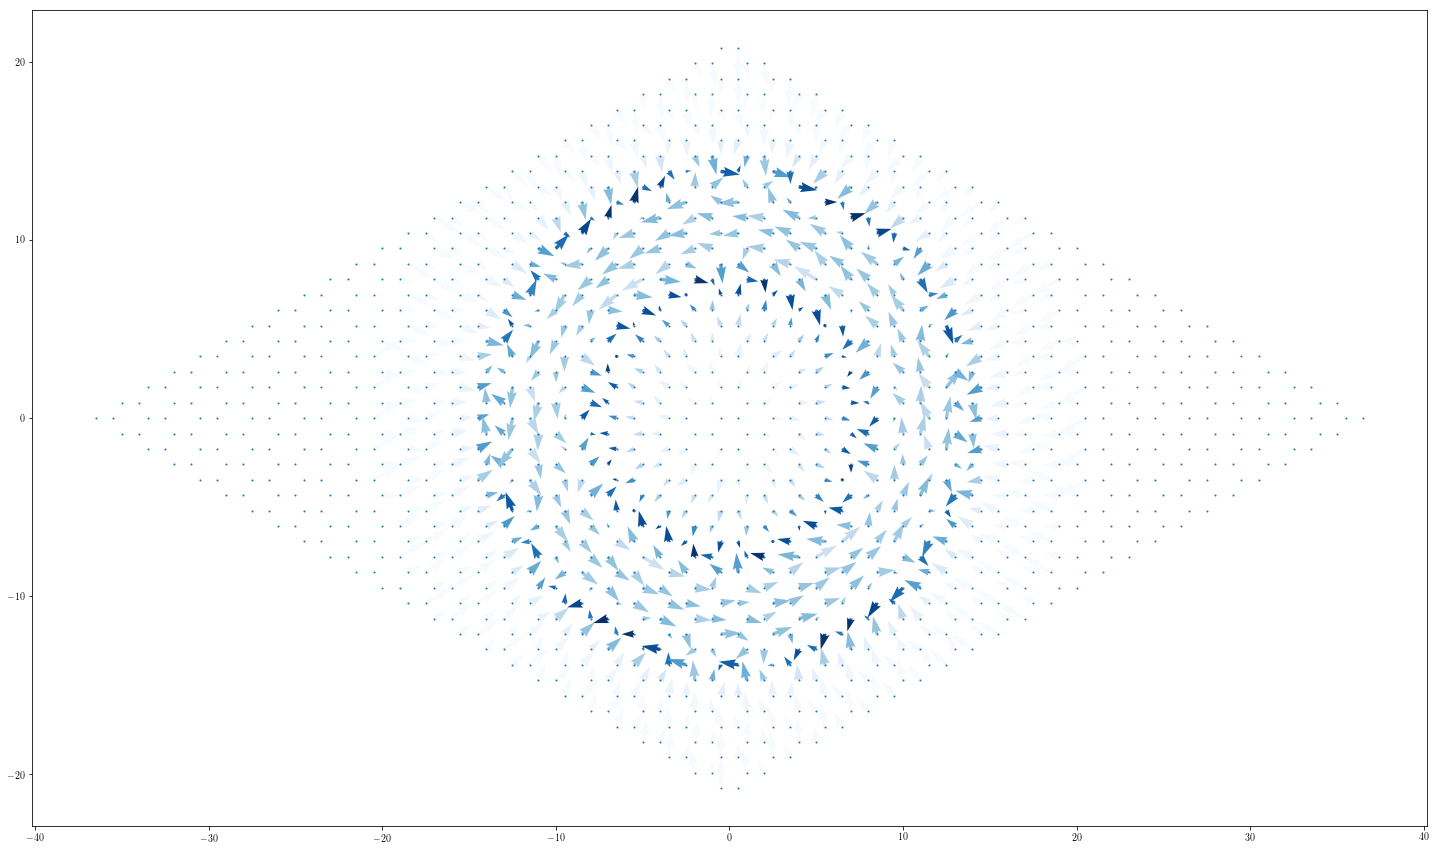

In [58]:
currents = 2*np.imag(ham.A*Γ)

x = lattice.xy_coords[:, 0]
y = lattice.xy_coords[:, 1]
u = np.zeros(lattice.L, np.float64)
v = np.zeros(lattice.L, np.float64)
c = np.zeros(lattice.L, np.float64)

for i in range(lattice.L):
    j = np.nonzero(currents[i] > 1e-7)[0]
    if len(j) > 0:
        u[i] = np.sum(currents[i, j]*lattice.xy_coords[j, 0])/np.sum(currents[i, j]) - x[i]
        v[i] = np.sum(currents[i, j]*lattice.xy_coords[j, 1])/np.sum(currents[i, j]) - y[i]
        c[i] = np.sum(currents[i, j])

fig = plt.figure(figsize=(25, 15))
plt.quiver(x, y, u, v, c, cmap='Blues', scale=1, units='xy', angles='xy', scale_units='xy')
plt.scatter(lattice.xy_coords[:, 0], lattice.xy_coords[:, 1], s=1)
plt.show()

### Occupations and currents

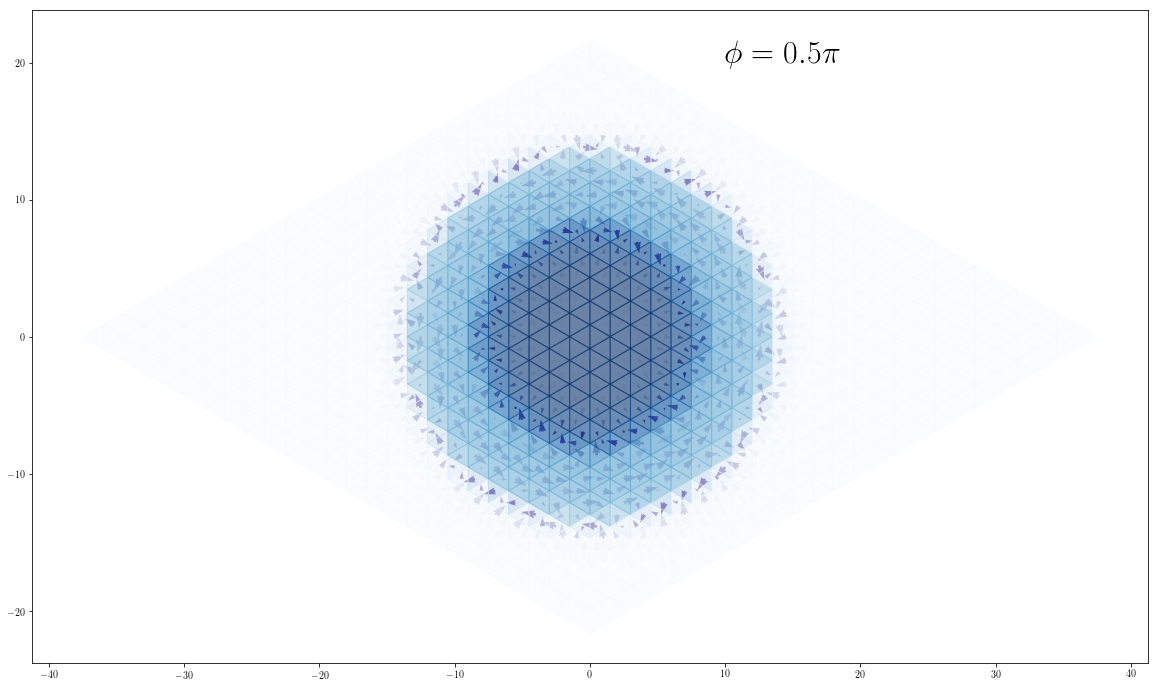

In [59]:
plt.figure(figsize=(20, 12))

data = occupations
norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='Blues')

fill_coords = np.zeros((lattice.L, 3, 2), np.float64)
disp_A = np.array([[-1, 0], [1/2, np.sqrt(3)/2], [1/2, -np.sqrt(3)/2]])
disp_B = np.array([[1, 0], [-1/2, np.sqrt(3)/2], [-1/2, -np.sqrt(3)/2]])
for i in range(lattice.L):
    if i%2 == 0:
        fill_coords[i] = lattice.xy_coords[i] + disp_A
    else:
        fill_coords[i] = lattice.xy_coords[i] + disp_B
    plt.fill(fill_coords[i, :, 0], fill_coords[i, :, 1],
             color=mapper.to_rgba(data[i]), alpha=0.6)

plt.quiver(x, y, u, v, c, cmap='Purples', scale=1, units='xy', angles='xy', scale_units='xy')
plt.text(10, 20, r'$\phi = {}\pi$'.format(dphi), fontsize=32)

plt.show()

### Chiral currents

To better observe the currents in the system we should plot total currents going through closed paths, like the closed triangle connecting all sites of a particular sublattice in one hexagon, both triangles, or both triangles and the current going through the edges of the hexagon. 

#### Coordinates of every closed hexagon in the lattice

In [60]:
# Relative coordinates of a single hexagon with respect to the lower left point.
hex_coords = np.array([[0, 0, 0], [-1, 0, 1], [-1, 1, 0],
                       [-1, 1, 1], [0, 1, 0], [0, 0, 1]], np.int64)

# Array with the indices of every point in every hexagon.
hexagons = np.zeros((lattice.L//2, 6), np.int64)
for i in range(0, lattice.L, 2):
    if (lattice.lat_coords[i][0] == 0) or (lattice.lat_coords[i][1] == lattice.Ny-1):
        continue
    i_coord = lattice.lat_coords[i]
    # Indices of the points that define an hexagon. If some index is -1, the hexagon is open.
    hex_ix = np.zeros(6, np.int64)
    for j in range(6):
        hexagons[i//2, j] = lattice.position_to_index(i_coord + hex_coords[j])

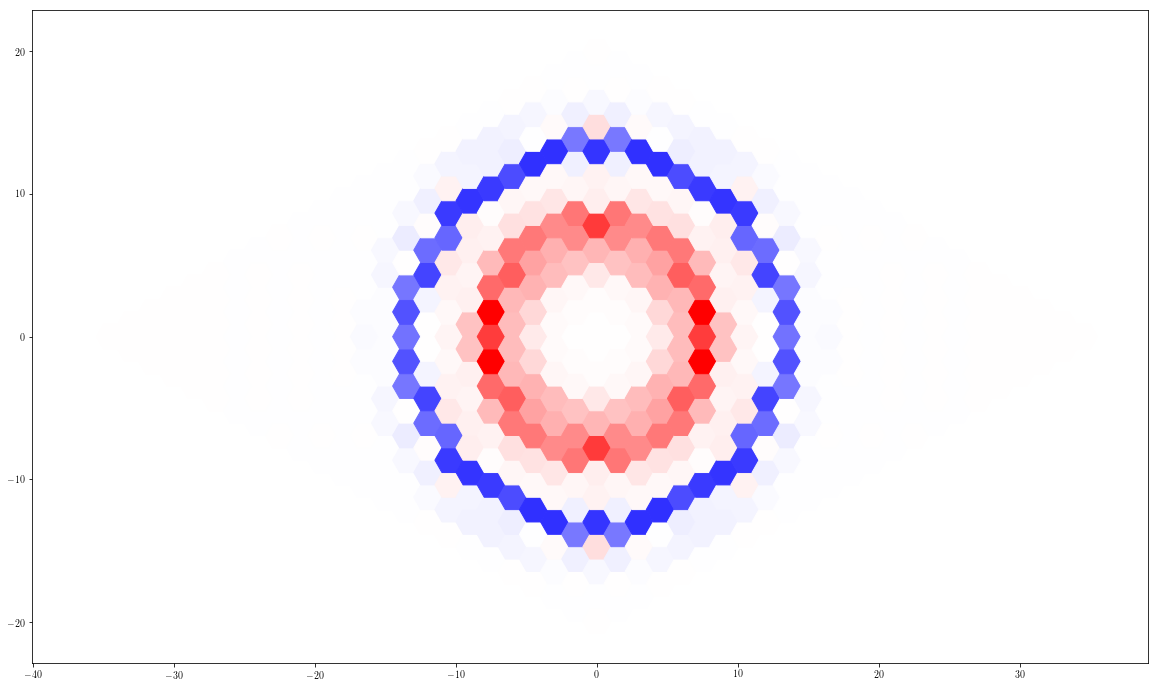

In [61]:
# Circular currents
circular_currents = np.zeros(hexagons.shape[0], np.float64)
for i in range(hexagons.shape[0]):
    for j in range(6):
        # First neighbor currents.
        circular_currents[i] += currents[hexagons[i, (j+1)%6], hexagons[i, j]]
    for j in range(3):
        # Sublattice A second neighbor currents.
        circular_currents[i] += currents[hexagons[i, (2*j+2)%6], hexagons[i, 2*j]]
        # Sublattice B second negihbor currents.
        circular_currents[i] += currents[hexagons[i, (2*j+3)%6], hexagons[i, 2*j+1]]

data = circular_currents
max_abs_data = np.max(np.abs(data))
norm = mpl.colors.Normalize(vmin=-max_abs_data, vmax=max_abs_data,
                            clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='bwr')
        
plt.figure(figsize=(20, 12))
for i in range(hexagons.shape[0]):
    plt.fill(lattice.xy_coords[hexagons[i], 0], lattice.xy_coords[hexagons[i], 1],
             color=mapper.to_rgba(data[i]))
plt.show()

## Time of flight images

Let's suppose we release the optic trap that simulated the Haldane model. We can consider that the particles will then expand as plane waves without interference between them. Therefore, the momentum distribution after we have released them from the trap will be

$$ \langle \psi^\dagger (\vec{k})\ \psi (\vec{k})\rangle \sim \sum_{ij} e^{i\vec{k}(\vec{x}_i - \vec{x}_j)} \langle a^\dagger_i a_j \rangle $$

This computation can be numerically done with ease if we first define a matrix

$$ U_{ki} = e^{-i\vec{k}\vec{x}_i}$$

Therefore

$$ \Gamma^{TOF}_{kk} = \langle \psi^\dagger (\vec{k})\ \psi (\vec{k})\rangle \sim \sum_{ij} U_{ki} \langle a^\dagger_i a_j \rangle U^*_{kj} $$

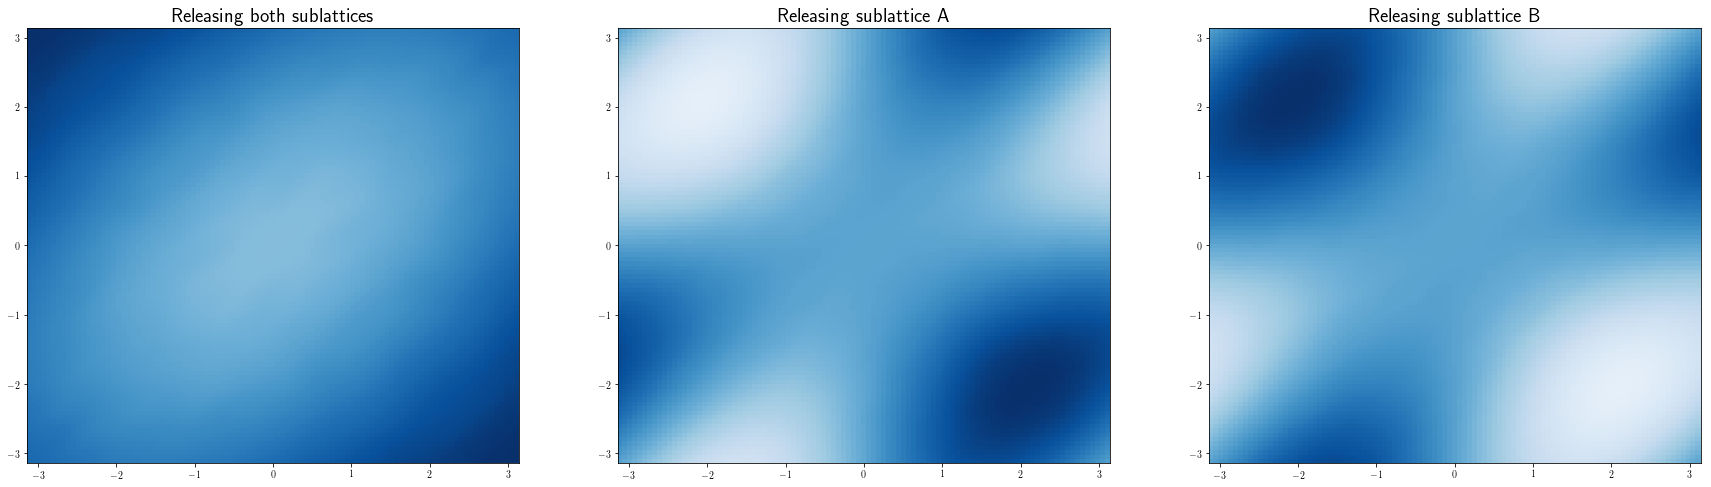

In [62]:
# Brillouin zone grid dimensions
grid_dims = 100
# Indices of the points
ikx, iky = np.meshgrid(np.linspace(-np.pi, np.pi, grid_dims), 
                       np.linspace(-np.pi, np.pi, grid_dims))
# Coordinates in the Brillouin zone
kx = 1/3*(ikx + iky)
ky = 1/np.sqrt(3)*(-ikx + iky)

# U matrix
kxr = np.ravel(kx)
kyr = np.ravel(ky)
xi = lattice.xy_coords[:, 0]
yi = lattice.xy_coords[:, 1]

# Releasing both sublattices
U = np.exp(-1j*(np.outer(kxr, xi) + np.outer(kyr, yi)))/grid_dims
Γ_tof = np.real(np.einsum('ki,ij,kj->k', U, Γ, np.conj(U), optimize=True))
im_Γ_tof = np.reshape(Γ_tof, (grid_dims, grid_dims))

# Releasing sublattice A
Ua = np.copy(U)
Ua[:, np.arange(1, lattice.L, 2)] = 0
Γ_tof_a = np.real(np.einsum('ki,ij,kj->k', Ua, Γ, np.conj(Ua), optimize=True))
im_Γ_tof_a = np.reshape(Γ_tof_a, (grid_dims, grid_dims))

# Releasing sublattice B
Ub = np.copy(U)
Ub[:, np.arange(0, lattice.L, 2)] = 0
Γ_tof_b= np.real(np.einsum('ki,ij,kj->k', Ub, Γ, np.conj(Ub), optimize=True))
im_Γ_tof_b = np.reshape(Γ_tof_b, (grid_dims, grid_dims))

plt.figure(figsize=(30, 8))
plt.subplot(1, 3, 1)
plt.title('Releasing both sublattices', fontsize=20)
plt.pcolormesh(ikx, iky, im_Γ_tof, cmap='Blues', vmin=0)
plt.subplot(1, 3, 2)
plt.title('Releasing sublattice A', fontsize=20)
plt.pcolormesh(ikx, iky, im_Γ_tof_a, cmap='Blues', vmin=0)
plt.subplot(1, 3, 3)
plt.title('Releasing sublattice B', fontsize=20)
plt.pcolormesh(ikx, iky, im_Γ_tof_b, cmap='Blues', vmin=0)

#### TOF of some small set of particles

We can change the spin of some particles and then release them from the trap to observe if their velocity due to the currents in the topological model has any imprint in the TOF images. The TOF is computed as

$$ \Gamma^{TOF,\downarrow}_{kk} = \langle \psi^\dagger (\vec{k})\ \psi (\vec{k})\rangle \sim \sum_{ij} U_{ki} \Gamma^\downarrow_{ij} U^*_{kj} $$

(array([1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1112,
       1114, 1116]),)


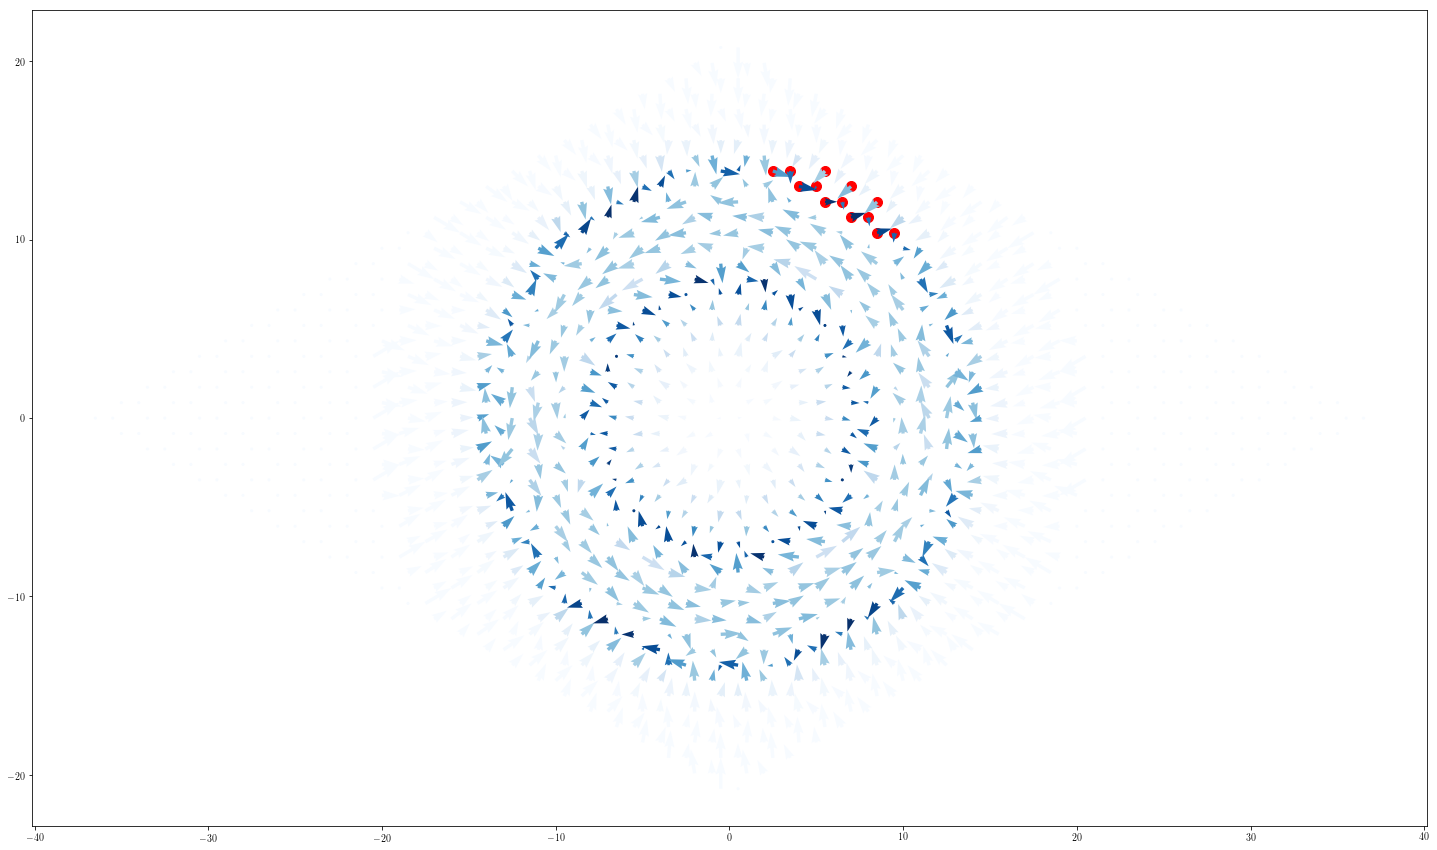

In [63]:
Ω = np.zeros(lattice.L, np.int64)
radius = np.linalg.norm(lattice.xy_coords, axis=1)
angle = np.arctan2(lattice.xy_coords[:, 1], lattice.xy_coords[:, 0])
ix_mask = np.nonzero(np.logical_and(
    np.logical_and(radius >= 13.2, radius < 15), 
    np.logical_and(angle > 0.25*np.pi, angle <= 0.45*np.pi)
    ))
print(ix_mask)
#ix_mask = [1060, 1062, 1064, 1066, 1068]
Ω[ix_mask] = 1

arrow_1_u = np.sum(c[ix_mask]*u[ix_mask])/np.sum(c[ix_mask])
arrow_1_v = np.sum(c[ix_mask]*v[ix_mask])/np.sum(c[ix_mask])
arrow_1_c = np.sum(c[ix_mask])

Γ_down = np.outer(Ω, Ω)*Γ
occupations_down = np.real(np.diag(Γ_down))

plt.figure(figsize=(25, 15))
plt.quiver(x, y, u, v, c, cmap='Blues', scale=1, units='xy', angles='xy', scale_units='xy', zorder=2)
plt.scatter(lattice.xy_coords[ix_mask, 0], lattice.xy_coords[ix_mask, 1], s=100, c='r')
plt.show()

Maxmimum density: 0.00010918980615215679


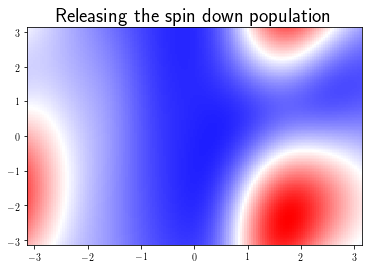

In [47]:
# Expected values in momentum space
Γ_tof_down = np.real(np.einsum('ki,ij,kj->k', U, Γ_down, np.conj(U), optimize=True))
# Normalize by particle number in spin down space
Γ_tof_down /= np.sum(occupations_down)
im_Γ_tof_down = np.reshape(Γ_tof_down, (grid_dims, grid_dims))
tmp_1 = im_Γ_tof_down

print('Maxmimum density: {}'.format(np.max(Γ_tof_down)))

plt.title('Releasing the spin down population', fontsize=20)
plt.pcolormesh(ikx, iky, im_Γ_tof_down, cmap='bwr', vmin=0)
plt.show()

(array([180, 182, 184, 186, 187, 188, 189]),)


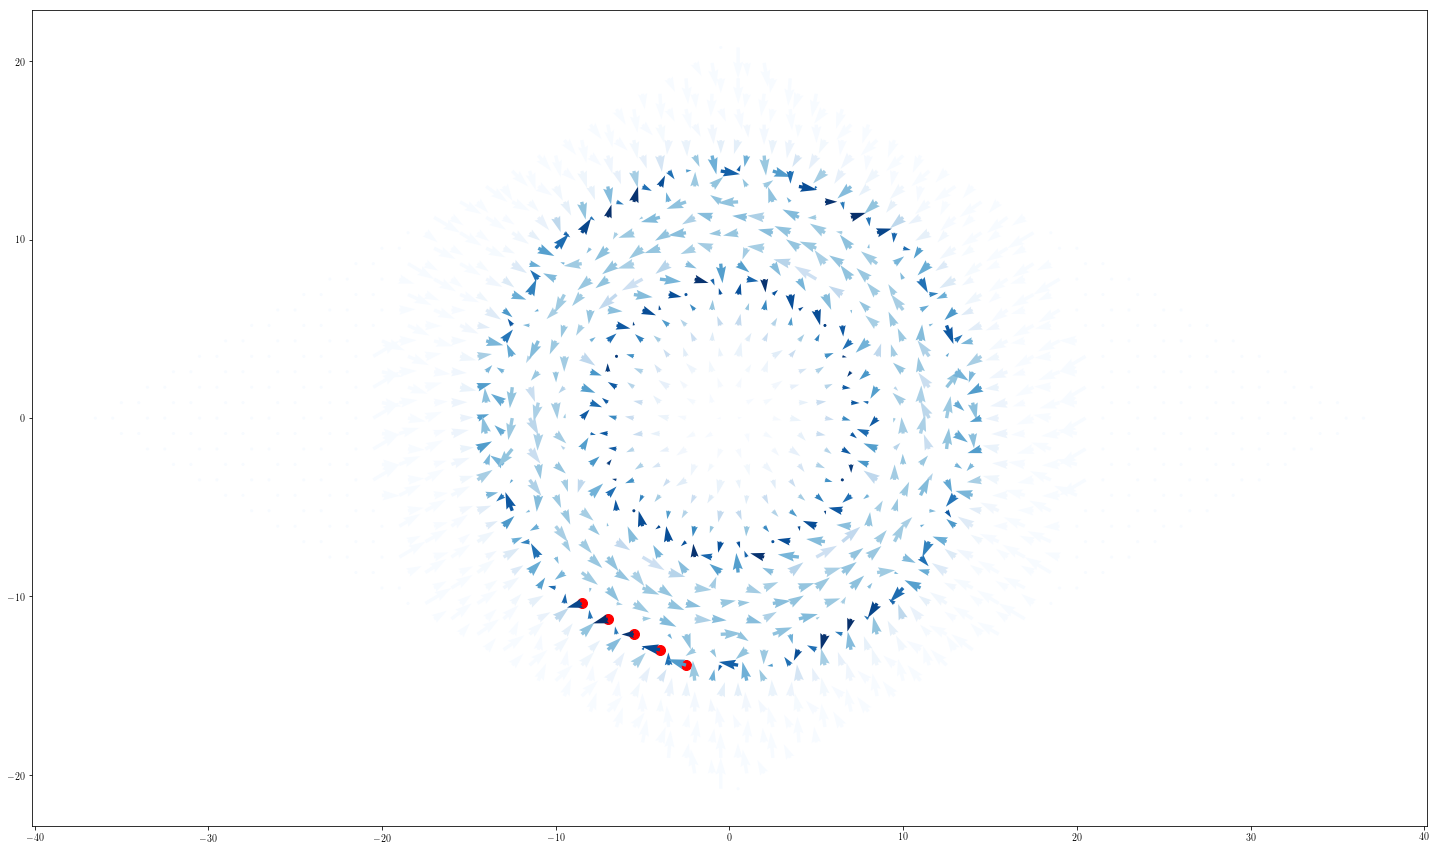

In [29]:
Ω = np.zeros(lattice.L, np.int64)
radius = np.linalg.norm(lattice.xy_coords, axis=1)
angle = np.arctan2(lattice.xy_coords[:, 1], lattice.xy_coords[:, 0])
ix_mask = np.nonzero(np.logical_and(
    np.logical_and(radius >= 13.5, radius < 14.5), 
    np.logical_and(angle > 0.25*np.pi-np.pi, angle <= 0.45*np.pi-np.pi)
    ))
print(ix_mask)
ix_mask = [181, 183, 185, 187, 189]
Ω[ix_mask] = 1

arrow_2_u = np.sum(c[ix_mask]*u[ix_mask])/np.sum(c[ix_mask])
arrow_2_v = np.sum(c[ix_mask]*v[ix_mask])/np.sum(c[ix_mask])
arrow_2_c = np.sum(c[ix_mask])

Γ_down = np.outer(Ω, Ω)*Γ
occupations_down = np.real(np.diag(Γ_down))

plt.figure(figsize=(25, 15))
plt.quiver(x, y, u, v, c, cmap='Blues', scale=1, units='xy', angles='xy', scale_units='xy', zorder=2)
plt.scatter(lattice.xy_coords[ix_mask, 0], lattice.xy_coords[ix_mask, 1], s=100, c='r')
plt.show()

Maxmimum density: 0.0002601272248961986


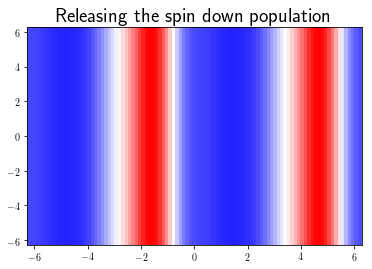

In [30]:
# Expected values in momentum space
Γ_tof_down = np.real(np.einsum('ki,ij,kj->k', U, Γ_down, np.conj(U), optimize=True))
# Normalize by particle number in spin down space
Γ_tof_down /= np.sum(occupations_down)
im_Γ_tof_down = np.reshape(Γ_tof_down, (grid_dims, grid_dims))
tmp_2 = im_Γ_tof_down

print('Maxmimum density: {}'.format(np.max(Γ_tof_down)))

plt.title('Releasing the spin down population', fontsize=20)
plt.pcolor(ikx, iky, im_Γ_tof_down, cmap='bwr', vmin=0)
plt.show()

(array([756, 806, 856, 906, 907, 956, 957]),)


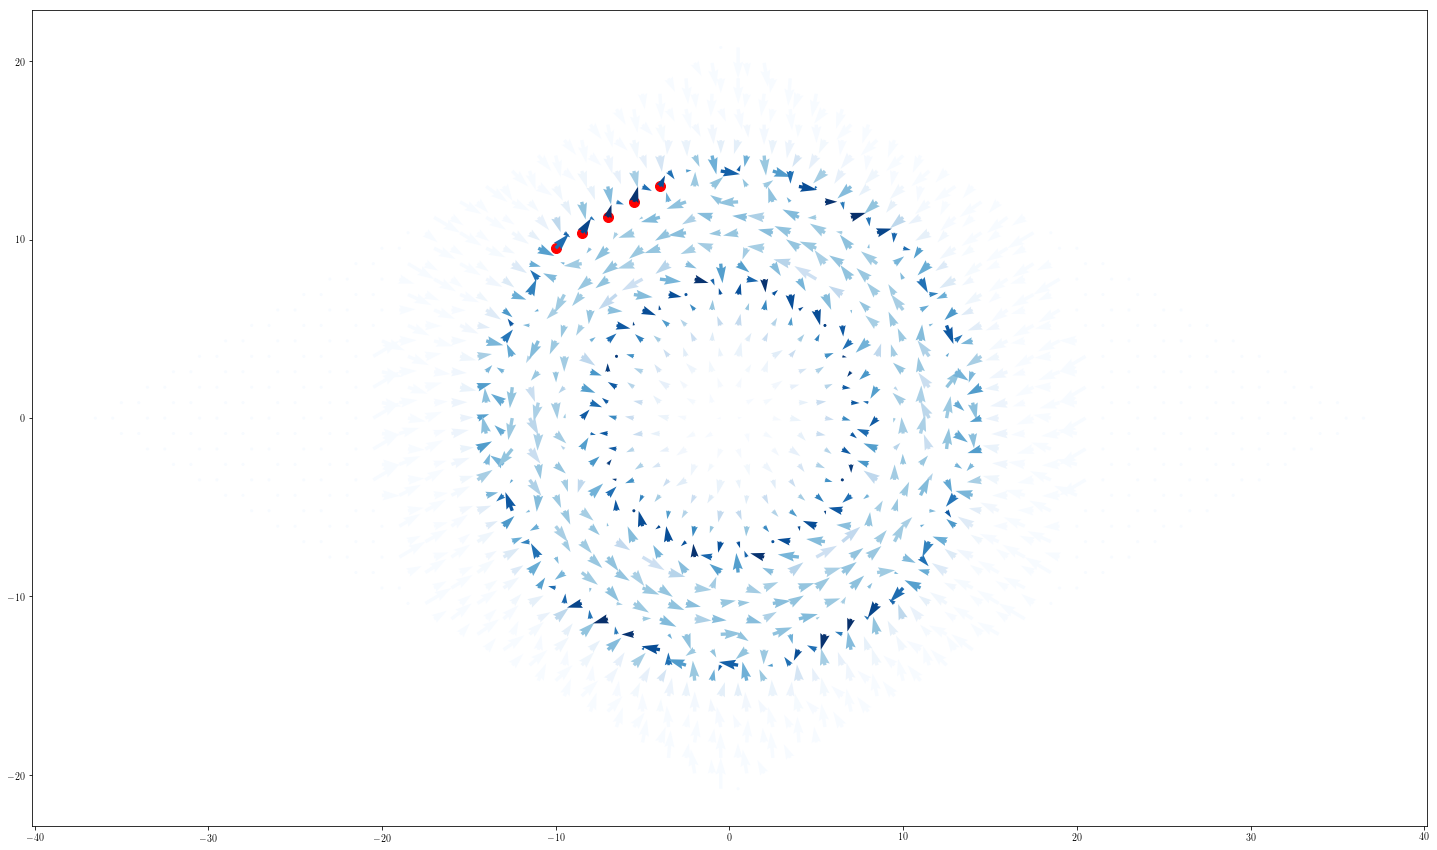

In [16]:
Ω = np.zeros(lattice.L, np.int64)
radius = np.linalg.norm(lattice.xy_coords, axis=1)
angle = np.arctan2(lattice.xy_coords[:, 1], lattice.xy_coords[:, 0])
ix_mask = np.nonzero(np.logical_and(
    np.logical_and(radius >= 13.5, radius < 14.5), 
    np.logical_and(angle > 0.55*np.pi, angle <= 0.75*np.pi)
    ))
print(ix_mask)
ix_mask = [907, 857, 807, 757, 707]
Ω[ix_mask] = 1

arrow_3_u = np.sum(c[ix_mask]*u[ix_mask])/np.sum(c[ix_mask])
arrow_3_v = np.sum(c[ix_mask]*v[ix_mask])/np.sum(c[ix_mask])
arrow_3_c = np.sum(c[ix_mask])

Γ_down = np.outer(Ω, Ω)*Γ
occupations_down = np.real(np.diag(Γ_down))

plt.figure(figsize=(25, 15))
plt.quiver(x, y, u, v, c, cmap='Blues', scale=1, units='xy', angles='xy', scale_units='xy', zorder=2)
plt.scatter(lattice.xy_coords[ix_mask, 0], lattice.xy_coords[ix_mask, 1], s=100, c='r')
plt.show()

Maxmimum density: 0.0002676988960320808


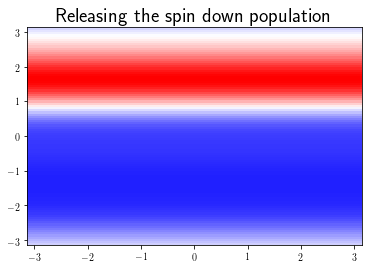

In [17]:
# Expected values in momentum space
Γ_tof_down = np.real(np.einsum('ki,ij,kj->k', U, Γ_down, np.conj(U), optimize=True))
# Normalize by particle number in spin down space
Γ_tof_down /= np.sum(occupations_down)
im_Γ_tof_down = np.reshape(Γ_tof_down, (grid_dims, grid_dims))
tmp_3 = im_Γ_tof_down

print('Maxmimum density: {}'.format(np.max(Γ_tof_down)))

plt.title('Releasing the spin down population', fontsize=20)
plt.pcolor(ikx, iky, im_Γ_tof_down, cmap='bwr', vmin=0)
plt.show()

Maxmimum density: 0.0002676988960320808


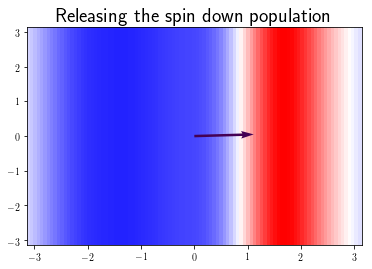

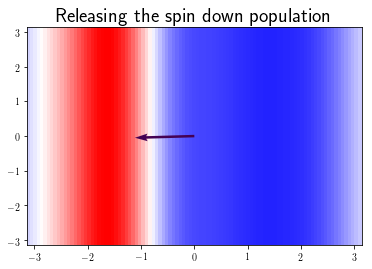

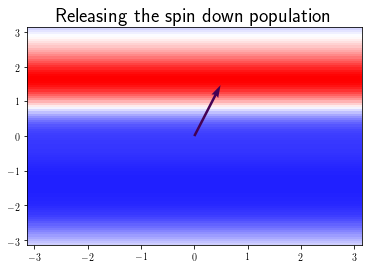

In [18]:
print('Maxmimum density: {}'.format(np.max(Γ_tof_down)))

plt.title('Releasing the spin down population', fontsize=20)
plt.quiver(arrow_1_u, arrow_1_v, arrow_1_c, scale=5, zorder=2)
plt.pcolormesh(ikx, iky, tmp_1, cmap='bwr', vmin=0)
plt.show()

plt.title('Releasing the spin down population', fontsize=20)
plt.quiver(arrow_2_u, arrow_2_v, arrow_2_c, scale=5, zorder=2)
plt.pcolormesh(ikx, iky, tmp_2, cmap='bwr', vmin=0)
plt.show()

plt.title('Releasing the spin down population', fontsize=20)
plt.quiver(arrow_3_u, arrow_3_v, arrow_3_c, scale=5, zorder=2)
plt.pcolormesh(ikx, iky, tmp_3, cmap='bwr', vmin=0)
plt.show()

#### Particles in the inner current

(array([867, 868, 869, 870, 871, 872, 873, 918, 920]),)


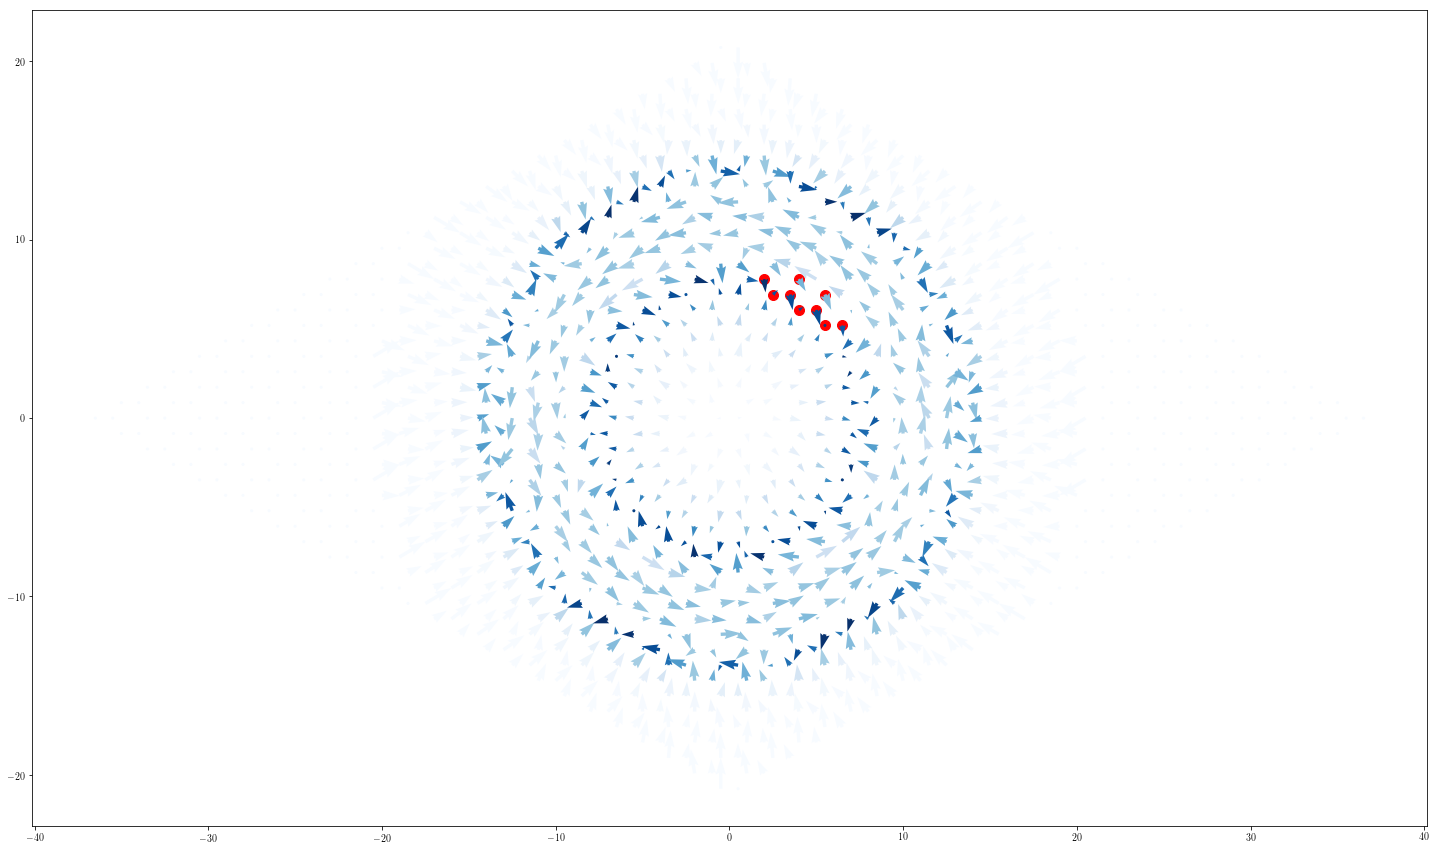

In [41]:
Ω = np.zeros(lattice.L, np.int64)
radius = np.linalg.norm(lattice.xy_coords, axis=1)
angle = np.arctan2(lattice.xy_coords[:, 1], lattice.xy_coords[:, 0])
ix_mask = np.nonzero(np.logical_and(
    np.logical_and(radius >= 7, radius < 9), 
    np.logical_and(angle > 0.2*np.pi, angle <= 0.45*np.pi)
    ))
print(ix_mask)
#ix_mask = [867, 869, 871, 873]
Ω[ix_mask] = 1

arrow_1_u = np.sum(c[ix_mask]*u[ix_mask])/np.sum(c[ix_mask])
arrow_1_v = np.sum(c[ix_mask]*v[ix_mask])/np.sum(c[ix_mask])
arrow_1_c = np.sum(c[ix_mask])

Γ_down = np.outer(Ω, Ω)*Γ
occupations_down = np.real(np.diag(Γ_down))

plt.figure(figsize=(25, 15))
plt.quiver(x, y, u, v, c, cmap='Blues', scale=1, units='xy', angles='xy', scale_units='xy', zorder=2)
plt.scatter(lattice.xy_coords[ix_mask, 0], lattice.xy_coords[ix_mask, 1], s=100, c='r')
plt.show()

Maxmimum density: 0.00011679378327150623


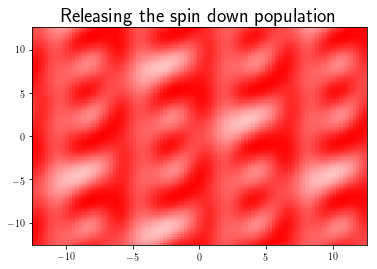

In [42]:
# Expected values in momentum space
Γ_tof_down = np.real(np.einsum('ki,ij,kj->k', U, Γ_down, np.conj(U), optimize=True))
# Normalize by particle number in spin down space
Γ_tof_down /= np.sum(occupations_down)
im_Γ_tof_down = np.reshape(Γ_tof_down, (grid_dims, grid_dims))
tmp_1 = im_Γ_tof_down

print('Maxmimum density: {}'.format(np.max(Γ_tof_down)))

plt.title('Releasing the spin down population', fontsize=20)
plt.pcolor(ikx, iky, im_Γ_tof_down, cmap='bwr', vmin=0)
plt.show()

(array([378, 379, 380, 381, 382]),)


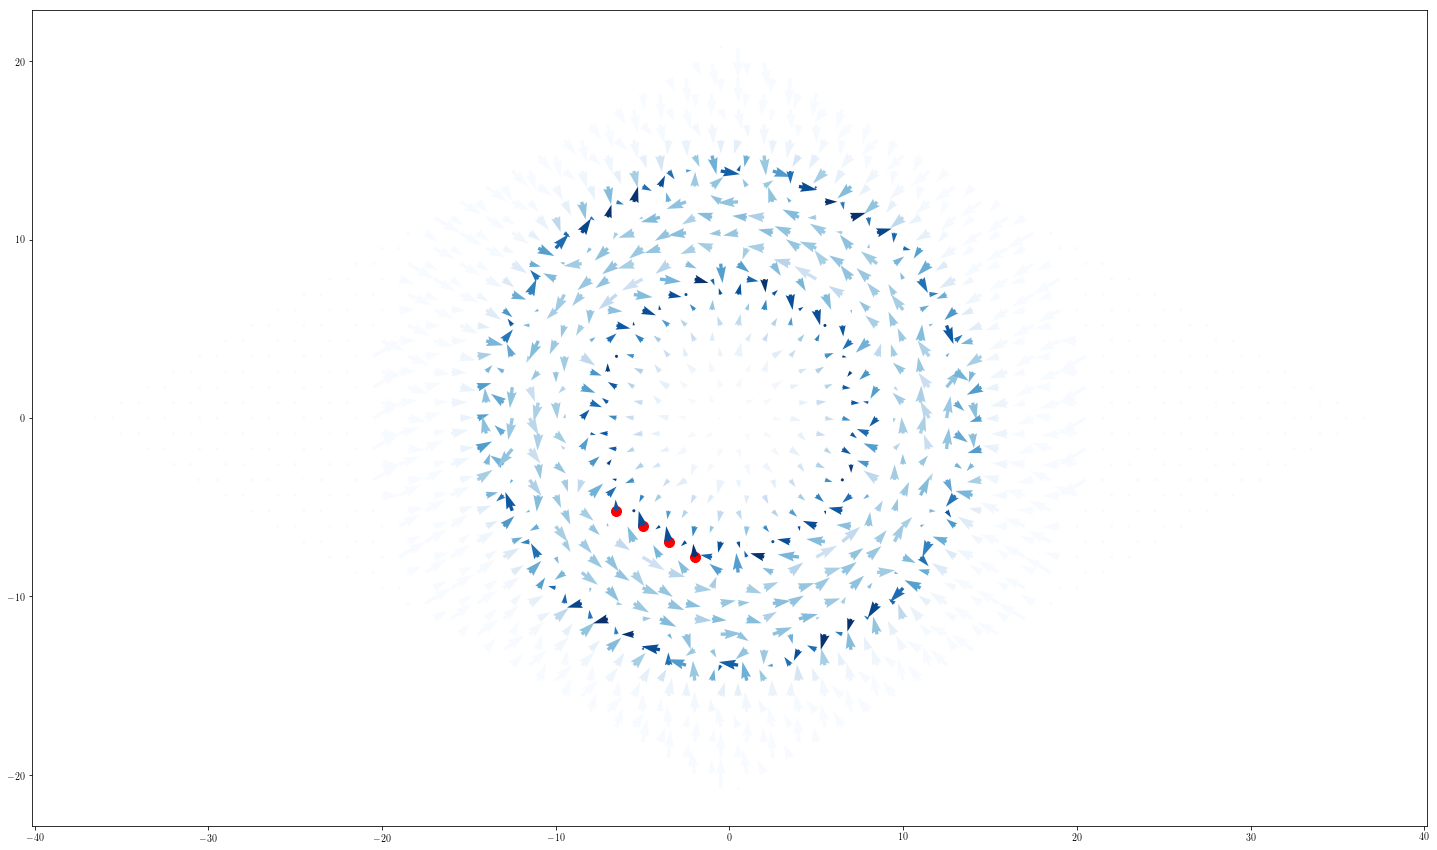

In [21]:
Ω = np.zeros(lattice.L, np.int64)
radius = np.linalg.norm(lattice.xy_coords, axis=1)
angle = np.arctan2(lattice.xy_coords[:, 1], lattice.xy_coords[:, 0])
ix_mask = np.nonzero(np.logical_and(
    np.logical_and(radius >= 7, radius < 8.5), 
    np.logical_and(angle > 0.25*np.pi-np.pi, angle <= 0.45*np.pi-np.pi)
    ))
print(ix_mask)
ix_mask = np.arange(376, 384, 2)
Ω[ix_mask] = 1

arrow_2_u = np.sum(c[ix_mask]*u[ix_mask])/np.sum(c[ix_mask])
arrow_2_v = np.sum(c[ix_mask]*v[ix_mask])/np.sum(c[ix_mask])
arrow_2_c = np.sum(c[ix_mask])

Γ_down = np.outer(Ω, Ω)*Γ
occupations_down = np.real(np.diag(Γ_down))

plt.figure(figsize=(25, 15))
plt.quiver(x, y, u, v, c, cmap='Blues', scale=1, units='xy', angles='xy', scale_units='xy', zorder=2)
plt.scatter(lattice.xy_coords[ix_mask, 0], lattice.xy_coords[ix_mask, 1], s=100, c='r')
plt.show()

Maxmimum density: 0.00011655209708803621


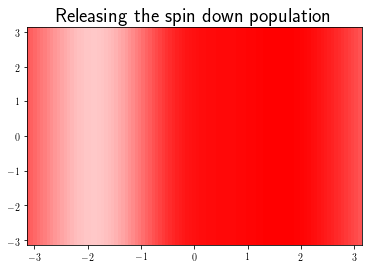

In [22]:
# Expected values in momentum space
Γ_tof_down = np.real(np.einsum('ki,ij,kj->k', U, Γ_down, np.conj(U), optimize=True))
# Normalize by particle number in spin down space
Γ_tof_down /= np.sum(occupations_down)
im_Γ_tof_down = np.reshape(Γ_tof_down, (grid_dims, grid_dims))
tmp_2 = im_Γ_tof_down

print('Maxmimum density: {}'.format(np.max(Γ_tof_down)))

plt.title('Releasing the spin down population', fontsize=20)
plt.pcolor(ikx, iky, im_Γ_tof_down, cmap='bwr', vmin=0)
plt.show()

(array([714, 715, 764, 765, 814]),)


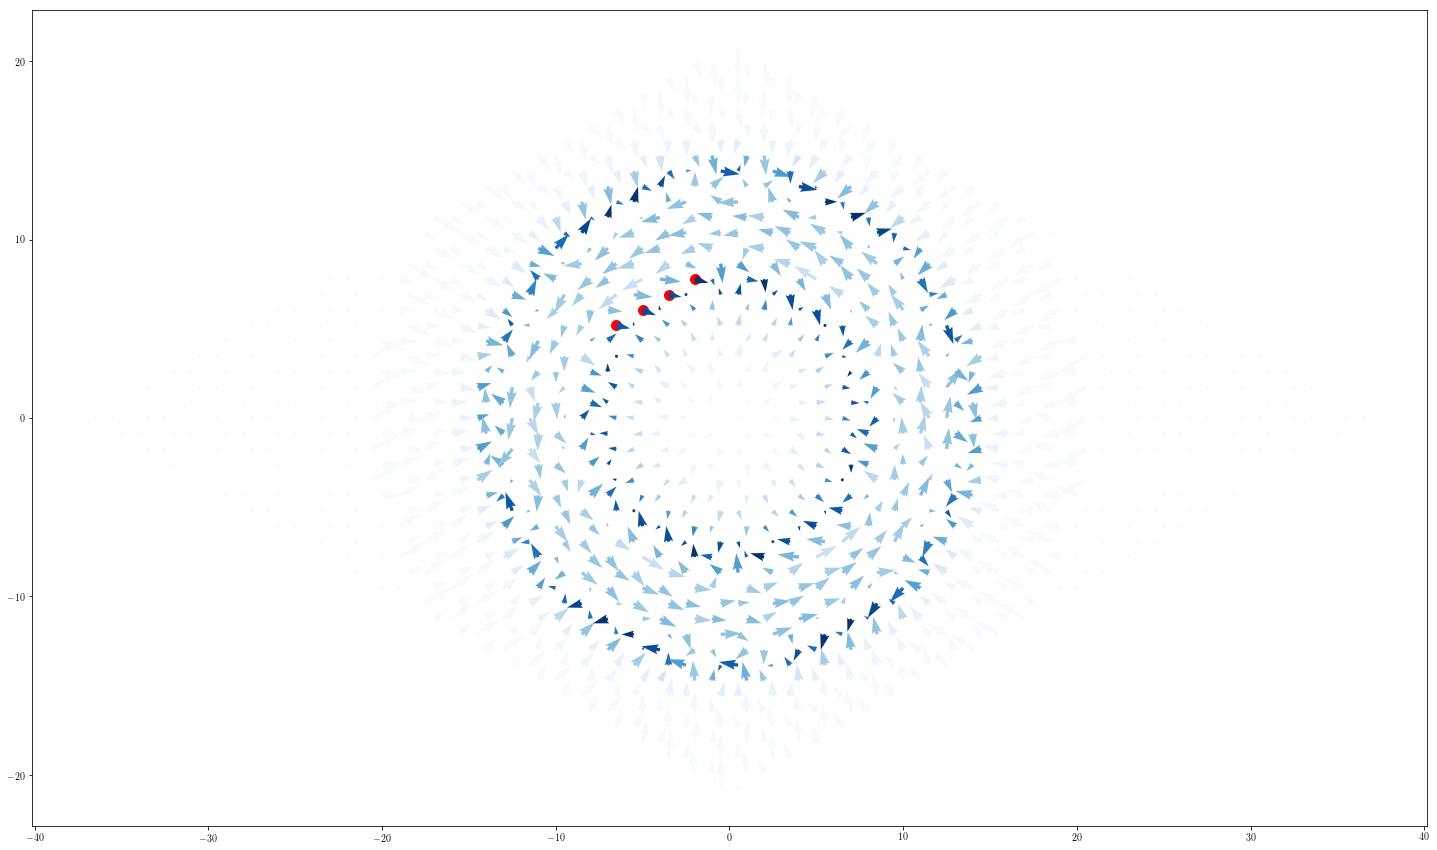

In [23]:
Ω = np.zeros(lattice.L, np.int64)
radius = np.linalg.norm(lattice.xy_coords, axis=1)
angle = np.arctan2(lattice.xy_coords[:, 1], lattice.xy_coords[:, 0])
ix_mask = np.nonzero(np.logical_and(
    np.logical_and(radius >= 7, radius < 8.5), 
    np.logical_and(angle > 0.55*np.pi, angle <= 0.75*np.pi)
    ))
print(ix_mask)
ix_mask = np.arange(664, 864, 50)
Ω[ix_mask] = 1

arrow_3_u = np.sum(c[ix_mask]*u[ix_mask])/np.sum(c[ix_mask])
arrow_3_v = np.sum(c[ix_mask]*v[ix_mask])/np.sum(c[ix_mask])
arrow_3_c = np.sum(c[ix_mask])

Γ_down = np.outer(Ω, Ω)*Γ
occupations_down = np.real(np.diag(Γ_down))

plt.figure(figsize=(25, 15))
plt.quiver(x, y, u, v, c, cmap='Blues', scale=1, units='xy', angles='xy', scale_units='xy', zorder=2)
plt.scatter(lattice.xy_coords[ix_mask, 0], lattice.xy_coords[ix_mask, 1], s=100, c='r')
plt.show()

Maxmimum density: 0.00011655209708803626
Minimum density: 7.091401314376654e-05


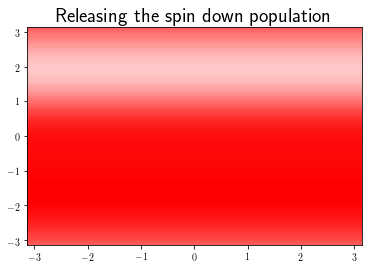

In [24]:
# Expected values in momentum space
Γ_tof_down = np.real(np.einsum('ki,ij,kj->k', U, Γ_down, np.conj(U), optimize=True))
# Normalize by particle number in spin down space
Γ_tof_down /= np.sum(occupations_down)
im_Γ_tof_down = np.reshape(Γ_tof_down, (grid_dims, grid_dims))
tmp_3 = im_Γ_tof_down

print('Maxmimum density: {}'.format(np.max(Γ_tof_down)))
print('Minimum density: {}'.format(np.min(Γ_tof_down)))

plt.title('Releasing the spin down population', fontsize=20)
plt.pcolor(ikx, iky, im_Γ_tof_down, cmap='bwr', vmin=0)
plt.show()

Maxmimum density: 0.00011655209708803626


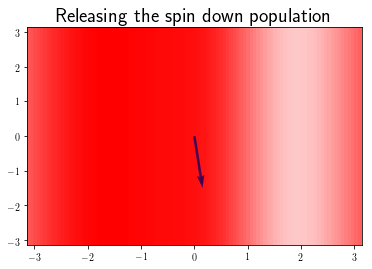

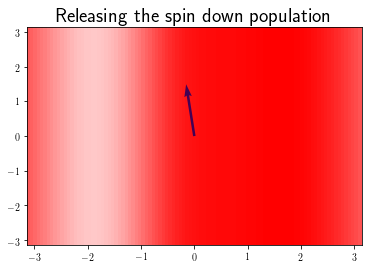

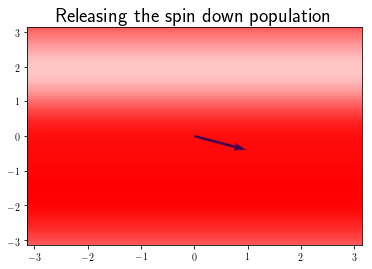

In [25]:
print('Maxmimum density: {}'.format(np.max(Γ_tof_down)))

plt.title('Releasing the spin down population', fontsize=20)
plt.quiver(arrow_1_u, arrow_1_v, arrow_1_c, scale=5, zorder=2)
plt.pcolormesh(ikx, iky, tmp_1, cmap='bwr', vmin=0)
plt.show()

plt.title('Releasing the spin down population', fontsize=20)
plt.quiver(arrow_2_u, arrow_2_v, arrow_2_c, scale=5, zorder=2)
plt.pcolormesh(ikx, iky, tmp_2, cmap='bwr', vmin=0)
plt.show()

plt.title('Releasing the spin down population', fontsize=20)
plt.quiver(arrow_3_u, arrow_3_v, arrow_3_c, scale=5, zorder=2)
plt.pcolormesh(ikx, iky, tmp_3, cmap='bwr', vmin=0)
plt.show()

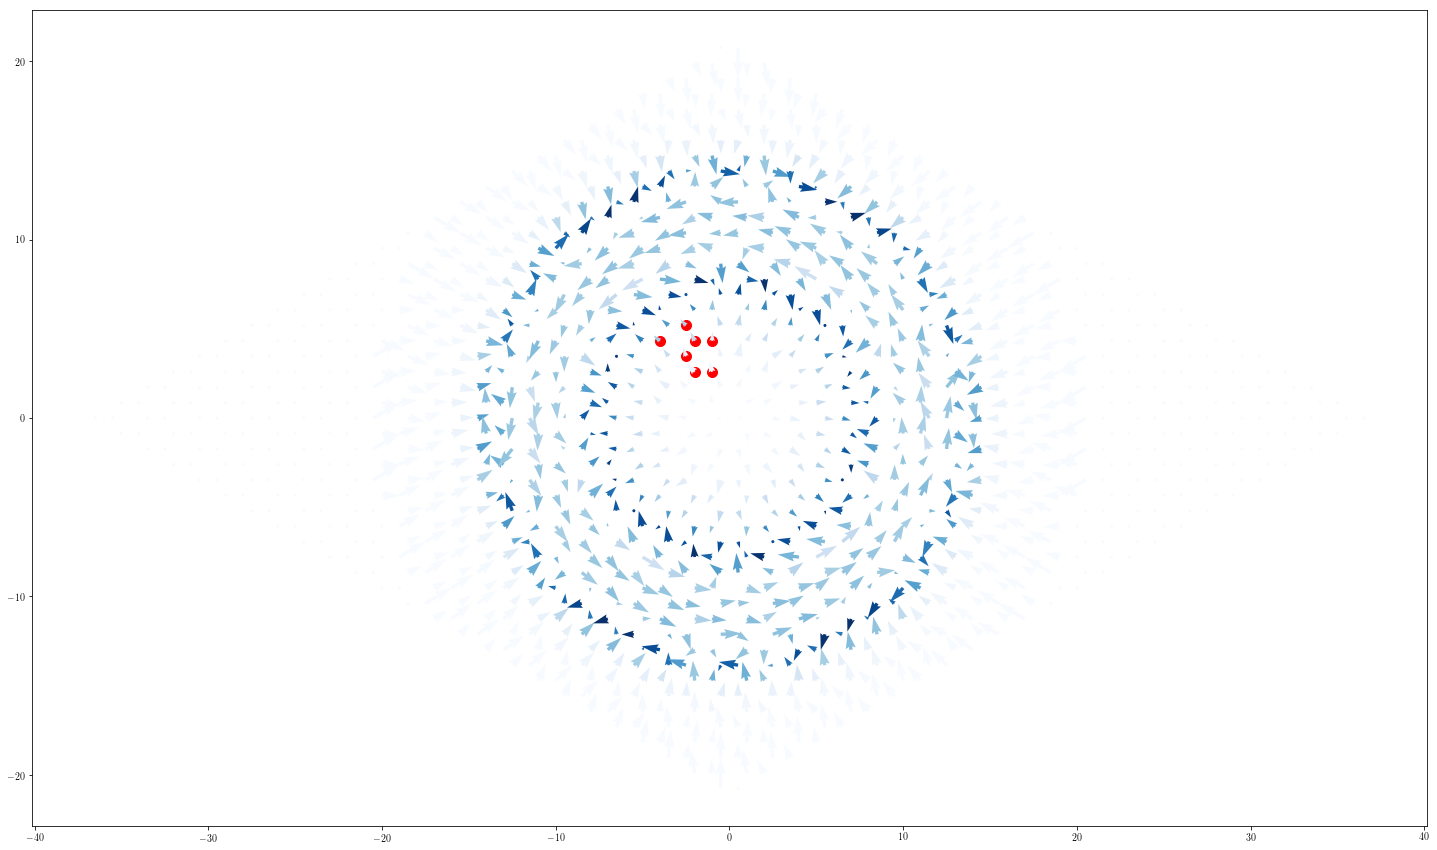

In [26]:
Ω = np.zeros(lattice.L, np.int64)
radius = np.linalg.norm(lattice.xy_coords, axis=1)
angle = np.arctan2(lattice.xy_coords[:, 1], lattice.xy_coords[:, 0])
ix_mask = np.nonzero(np.logical_and(
    np.logical_and(radius >= 2, radius < 6), 
    np.logical_and(angle > 0.55*np.pi, angle <= 0.75*np.pi)
    ))
Ω[ix_mask] = 1

arrow_3_u = np.sum(c[ix_mask]*u[ix_mask])/np.sum(c[ix_mask])
arrow_3_v = np.sum(c[ix_mask]*v[ix_mask])/np.sum(c[ix_mask])
arrow_3_c = np.sum(c[ix_mask])

Γ_down = np.outer(Ω, Ω)*Γ
occupations_down = np.real(np.diag(Γ_down))

plt.figure(figsize=(25, 15))
plt.quiver(x, y, u, v, c, cmap='Blues', scale=1, units='xy', angles='xy', scale_units='xy', zorder=2)
plt.scatter(lattice.xy_coords[ix_mask, 0], lattice.xy_coords[ix_mask, 1], s=100, c='r')
plt.show()

Maxmimum density: 0.00010121323215200695
Minmimum density: 9.746963475833385e-05


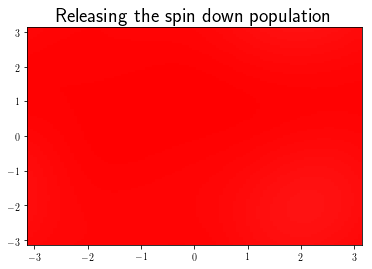

In [27]:
# Expected values in momentum space
Γ_tof_down = np.real(np.einsum('ki,ij,kj->k', U, Γ_down, np.conj(U), optimize=True))
# Normalize by particle number in spin down space
Γ_tof_down /= np.sum(occupations_down)
im_Γ_tof_down = np.reshape(Γ_tof_down, (grid_dims, grid_dims))

print('Maxmimum density: {}'.format(np.max(Γ_tof_down)))
print('Minmimum density: {}'.format(np.min(Γ_tof_down)))

plt.title('Releasing the spin down population', fontsize=20)
plt.pcolor(ikx, iky, im_Γ_tof_down, cmap='bwr', vmin=0)
plt.show()

## Reverting the spin of some particles

We can try to revert the spin of a set of particles and see if their time evolution gives us any information about the topological currents. To do so, we select a subset of particles $X$ that we want to revert the spin and extract them out of the system. We will let them evolve in a Hamiltonian without currents (a graphene model).

Let's suppose we have inverted some spin up particles that are now described by the correlation matrix $\Gamma^\downarrow_{ij} = \langle a^\dagger_{i\downarrow} a_{j\downarrow} \rangle$. We can write this matrix in the eigenbasis of the Hamiltonian $\Gamma^\downarrow_{kk'} = V^\dagger \Gamma^\downarrow_{ij} V$. This has the advantage that the Hamiltonian takes a diagonal form and, therefore, the time evolution takes a much simpler form

$$ \frac{d}{dt}\Gamma^\downarrow_{kk'} = -i\left(E_{k'}- E_k\right)\Gamma^\downarrow_{kk'} $$

therefore

$$ \Gamma^\downarrow_{kk'}(t) = \Gamma^\downarrow_{kk'}(0)\ e^{-i\left(E_{k'}- E_k\right)t}$$

As long as we want to observe movement in position space, we have to write it back in the original basis. Thus

$$ \Gamma^\downarrow_{ij}(t) = \sum_{kk'} V^*_{ik}\ \Gamma^\downarrow_{kk'}(t) V_{jk'} = \sum_{kk'} V^*_{ik}\ \Gamma^\downarrow_{kk'}(0)\ e^{-i\left(E_{k'}- E_k\right)t} V_{jk'} = \sum_{kk'mn} V^*_{ik}V_{mk}\ \Gamma^\downarrow_{mn} (0) V^*_{nk'} V_{jk'}\ e^{-i\left(E_{k'}- E_k\right)t}$$

We can simplilfy the expression by defining

$$ W_{jn} = \sum_k V_{jk}\ e^{-iE_k t}\ V^*_{nk}$$

such that

$$ \Gamma^\downarrow_{ij}(t) = \sum_{mn} W^*_{im}\ \Gamma^\downarrow_{mn}(0)\ W_{jn}$$

#### Hamiltonian without currents

In [29]:
hopping_params = (t1, t2, 0)
ham = OpenHamiltonian(lattice, hopping_params, hoppings_type,
                      trap_potential, lattice_imbalance)
w_eig, v_eig = eigh(ham.A)

#### Initial spin down population

(array([1009, 1010, 1011, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065,
       1066, 1067, 1112, 1114, 1116]),)


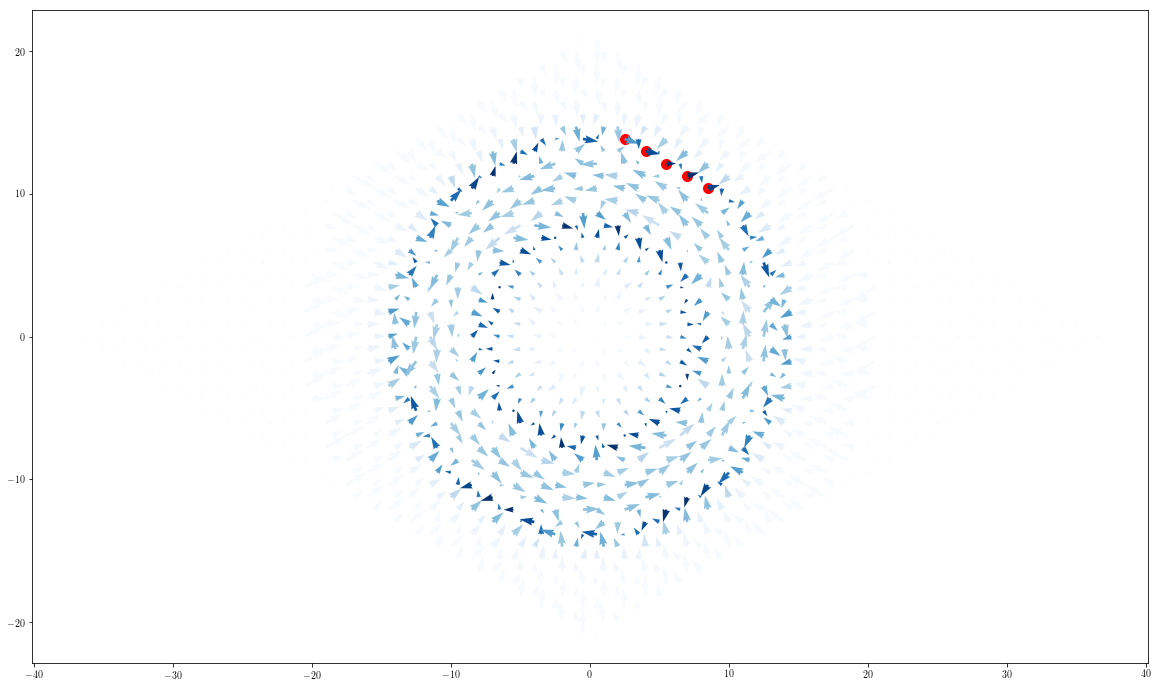

In [45]:
Ω = np.zeros(lattice.L, np.int64)
radius = np.linalg.norm(lattice.xy_coords, axis=1)
angle = np.arctan2(lattice.xy_coords[:, 1], lattice.xy_coords[:, 0])
ix_mask = np.nonzero(np.logical_and(
    np.logical_and(radius >= 13, radius < 15), 
    np.logical_and(angle > 0.3*np.pi, angle <= 0.5*np.pi)
    ))
print(ix_mask)
ix_mask = np.arange(1060, 1070, 2)
Ω[ix_mask] = 1

Γ_down = np.outer(Ω, Ω)*Γ
occupations_down = np.real(np.diag(Γ_down))

plt.figure(figsize=(20, 12))
if not np.isclose(np.linalg.norm(c), 0):
    # Currents and spin down population.
    plt.quiver(x, y, u, v, c, cmap='Blues', scale=1, units='xy', angles='xy', scale_units='xy', zorder=2)
    plt.scatter(lattice.xy_coords[ix_mask, 0], lattice.xy_coords[ix_mask, 1], s=100, c='r')
else:
    # Densities and spin down population.
    plot_voronoi(lattice, occupations, colormap='bwr')
    plt.scatter(lattice.xy_coords[ix_mask, 0], lattice.xy_coords[ix_mask, 1], s=100, c='k', zorder=2)
plt.show()

#### Time evolution of the spin down population

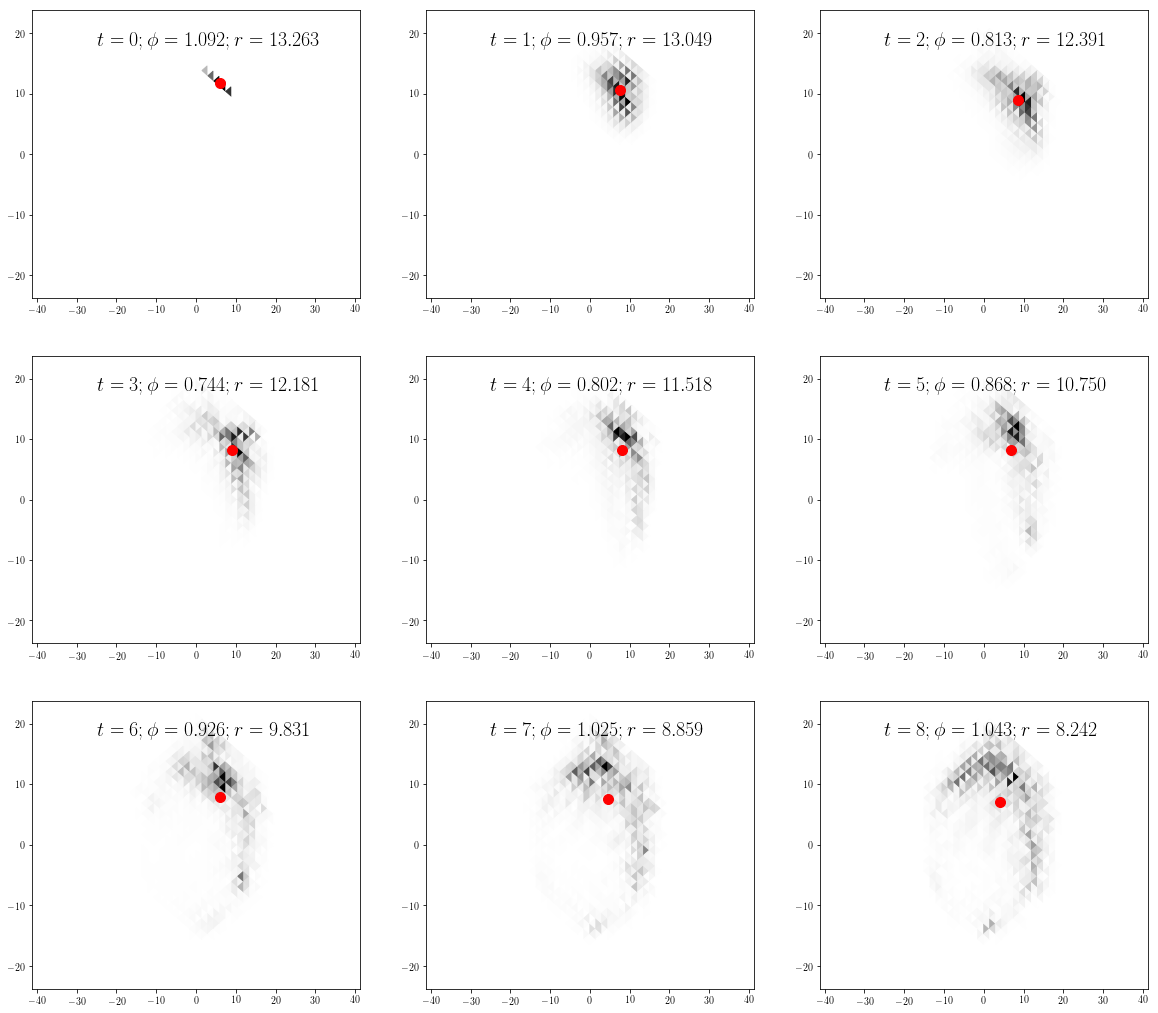

In [46]:
# Final times
times = np.arange(9)

plt.figure(figsize=(20,18))

for ix, t in enumerate(times):
    tmp_exp = np.exp(-1j*w_eig*t)
    W = np.einsum('jk,k,nk->jn', v_eig, tmp_exp, np.conj(v_eig), optimize=True)
    occupations_down_t = np.real(
        np.einsum('im,mn,in->i', np.conj(W), Γ_down, W, optimize=True)
        )
    
    data = occupations_down_t

    plt.subplot(3, 3, ix+1)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=np.max(data), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap='binary')

    fill_coords = np.zeros((lattice.L, 3, 2), np.float64)
    disp_A = np.array([[-1, 0], [1/2, np.sqrt(3)/2], [1/2, -np.sqrt(3)/2]])
    disp_B = np.array([[1, 0], [-1/2, np.sqrt(3)/2], [-1/2, -np.sqrt(3)/2]])
    for i in range(lattice.L):
        if i%2 == 0:
            fill_coords[i] = lattice.xy_coords[i] + disp_A
        else:
            fill_coords[i] = lattice.xy_coords[i] + disp_B
        plt.fill(fill_coords[i, :, 0], fill_coords[i, :, 1],
                 color=mapper.to_rgba(data[i]), alpha=1)
        
    # Mean density
    mean_x = np.sum(occupations_down_t*lattice.xy_coords[:, 0])/np.sum(occupations_down_t)
    mean_y = np.sum(occupations_down_t*lattice.xy_coords[:, 1])/np.sum(occupations_down_t)
    mean_phi = np.arctan2(mean_y, mean_x)
    mean_r = np.sqrt(mean_x**2 + mean_y**2)
    plt.scatter(mean_x, mean_y, s=100, c='r', zorder=2)
    plt.text(-25, 18, r'$t = {}; \phi = {:4.3f}; r = {:4.3f}$'.format(t, mean_phi, mean_r), fontsize=20)
        
plt.show()